In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
features = pd.read_csv('Lesson_2_features.csv')
sales = pd.read_csv('Lesson_2_sales.csv')
stores = pd.read_csv('Lesson_2_stores.csv')

In [3]:
features["CPI"] = features["CPI"].fillna(features["CPI"].median())
features["Unemployment"] = features["Unemployment"].fillna(features["Unemployment"].median())
features['Temperature'] = (features['Temperature']- 32) * 5./9.

In [4]:
holidays_factor, types = sales['IsHoliday'].factorize()
sales['IsHoliday'] = holidays_factor

In [5]:
df = pd.merge(sales, features, on = ['Store','Date', 'IsHoliday'], how = 'left')
df = pd.merge(df, stores, on = ['Store'], how = 'left')
df['Date'] = pd.to_datetime(df['Date'])

In [17]:
new_df = df[["Store", "Dept", "Date", "Weekly_Sales", "IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', "Type", "Size"]]

In [18]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 12 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null object
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
Type            421570 non-null object
Size            421570 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 41.8+ MB


In [19]:
new_df.fillna(0, inplace=True)

In [20]:
df_weekly = new_df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_weekly['Date']=pd.to_datetime(df_weekly['Date'])
df_weekly.set_index('Date', inplace=True)

In [21]:
orders=np.array([1,6,29,46,52])

In [22]:
ext_variables = new_df.groupby(by=['Date'], as_index=False)[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean()
ext_variables = ext_variables.set_index('Date')
ext_variables.head(3)

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-01-10,0.0,0.0,0.0,0.0,0.0
2010-02-04,0.0,0.0,0.0,0.0,0.0
2010-02-07,0.0,0.0,0.0,0.0,0.0


In [23]:
X = np.array([df_weekly.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(df_weekly))])

In [24]:
X = np.append(X, ext_variables.values, axis=1)

In [25]:
Y = df_weekly.values

In [26]:
na_filter = ~np.isnan(X[:,:1]).squeeze()

In [27]:
model_with_external = LinearRegression()
model_with_external.fit(X[na_filter], Y[na_filter].ravel())
coef = model_with_external.coef_
intercept = model_with_external.intercept_

In [28]:
X = np.array([df_weekly.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(df_weekly))])
    
X = np.append(X, ext_variables.values, axis=1)
    
predict_ext = np.array( np.dot(X, coef.T) + intercept)
    

In [29]:
pred_ext_df = pd.DataFrame(index=df_weekly.index, data=predict_ext)

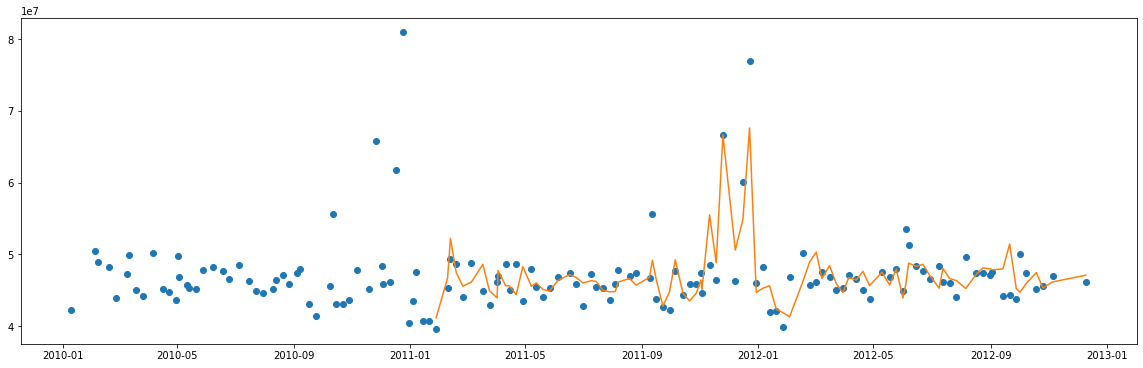

In [30]:
plt.figure(figsize=(20,6))
plt.plot(df_weekly, 'o')
plt.plot(pred_ext_df)
plt.show()

In [31]:
residuals = (df_weekly['Weekly_Sales'] - pred_ext_df[0]) / df_weekly['Weekly_Sales']

In [32]:
print('Model Residuals: среднее %.4f, стандартное отклонение %.4f' % (residuals.mean(), residuals.std()))

Model Residuals: среднее -0.0029, стандартное отклонение 0.0564
